# 1 Load Data

Load sales data from S3 / HDFS. We use the built-in "csv" method, which can use the first line has column names and which also supports infering the schema automatically. We use both and save some code for specifying the schema explictly.

We also peek inside the data by retrieving the first five records.

In [5]:
from pyspark.sql.functions import *

data = spark.read\
    .option("header","true")\
    .option("inferSchema","true")\
    .csv("s3://dimajix-training/data/kc-house-data")

data.limit(5).toPandas()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## 1.1 Inspect Schema

Now that we have loaded the data and that the schema was inferred automatically, let's inspect it.

In [6]:
data.printSchema()

root
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- price: decimal(7,0) (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)



# 2 Initial Investigations

As a first step to get an idea of our data, we create some simple visualizations. We use the Python matplot lib package for creating simple two-dimensional plots, where the x axis will be one of the provided attributes and the y axis will be the house price.

In [7]:
%matplotlib inline

In [8]:
# Import relevant Python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2.1 House Price in Relation to sqft_living

Probably one of the most important attributes is the size of the house. This is provided in the data in the column "sqft_living". We extract the price column and the sqft_living column and create a simple scatter plot.

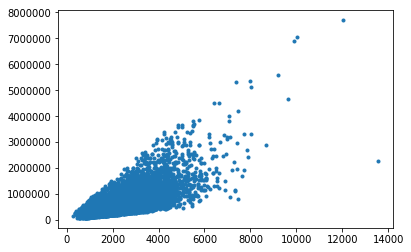

In [9]:
# Extract price and one of the attributes
price = data.select("price").toPandas()
sqft_living = data.select("sqft_living").toPandas()

# Create simple scatter plot
plt.plot(sqft_living, price, ".")

## 2.2 House Price in Relation to sqft_lot

Another interesting attribute for predicting the house price might be the size of the whole lot, which is provided in the column "sqft_lot". So let's create another plot, now with "price" and "sqft_lot".

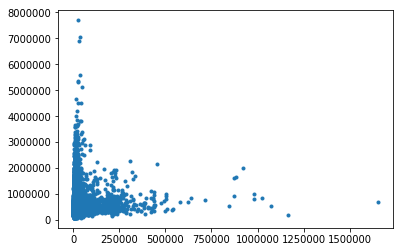

In [10]:
price = data.select("price").toPandas()
sqft_lot = data.select("sqft_lot").toPandas()

plt.plot(sqft_lot, price, ".")

## 2.3 House Price in Relation to bathrooms

In [ ]:
price = data.select("price").toPandas()
sqft_lot = data.select("bathrooms").toPandas()

plt.plot(sqft_lot, price, ".")

# 3 Build Simple Linear Model

Now since there seems to be some relation between the house price and some attributes, we try to fit a linear model to our data. This will be performed in multiple small steps. Later on we will see a more concise syntax for specifying all steps.

## 3.1 Extract features by using VectorAssembler

Most Spark ML methods require one feature column of type `Vector`. In order to generate this feature column from the raw data, Spark provides a `VectorAssembler` which assembles one feature column from arbitrary source columns. The source columns have to be of type `double`.

We use it to automatically extract the columns

    bedrooms, bathrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15

into the new output column 'features'

In [11]:
from pyspark.ml.feature import *

tx = VectorAssembler(inputCols=[
        'bedrooms',
        'bathrooms',
        'sqft_living',
        'sqft_lot',
        'sqft_above',
        'sqft_basement',
        'sqft_living15',
        'sqft_lot15'
    ],
    outputCol='features')

td = tx.transform(raw_data)
td.printSchema()

root
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- price: decimal(7,0) (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)
 |-- features: vector (nullable = true)



Let us have a look at the data

In [12]:
td.limit(5).toPandas()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,features
0,7129300520,20141013T000000,221900,3,1.00,1180,5650,1.0,0,0,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,"[3.0, 1.0, 1180.0, 5650.0, 1180.0, 0.0, 1340.0..."
1,6414100192,20141209T000000,538000,3,2.25,2570,7242,2.0,0,0,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,"[3.0, 2.25, 2570.0, 7242.0, 2170.0, 400.0, 169..."
2,5631500400,20150225T000000,180000,2,1.00,770,10000,1.0,0,0,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,"[2.0, 1.0, 770.0, 10000.0, 770.0, 0.0, 2720.0,..."
3,2487200875,20141209T000000,604000,4,3.00,1960,5000,1.0,0,0,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,"[4.0, 3.0, 1960.0, 5000.0, 1050.0, 910.0, 1360..."
4,1954400510,20150218T000000,510000,3,2.00,1680,8080,1.0,0,0,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,"[3.0, 2.0, 1680.0, 8080.0, 1680.0, 0.0, 1800.0..."


## 3.2 Split training / validation set

Now we need to split the data into a training and a validation set. Spark already provides a DataFrame method called `randomSplit` which takes an array of weights (between 0 and 1) and creates as many subsets. In our example, we want to create a training data set with 80% and the validation set should contain the remaining 20%.

In [13]:
# Split the data - 80% for training, 20% for validation
(training_data, validation_data) = data.randomSplit([0.8,0.2])

print("training_data = " + str(training_data.count()))
print("validation_data = " + str(validation_data.count()))

training_data = 17251
validation_data = 4362


## 3.3 Build Model

Now that we have split up our data, we can fit a model to the training data. But before doing so, we again need to apply the `VectorAssembler` to the data to extract the features column

In [15]:
from pyspark.ml.regression import *

# Create a LinearRegession algorithm and configure it to match our data
regression = LinearRegression(featuresCol='features', labelCol='price', predictionCol='prediction')

# Train a linear model using the regression above
model = regression.fit(tx.transform(training_data))

## 3.4 Predict

Make predictions from test data and print some results. We use the `validation_data` DataFrame (which was not used during training). Since this DataFrame does not already contain the feature column, we also need to apply the previously configured `VectorAssembler`.

In [16]:
# Create features using the VectorAssembler
validation_features = tx.transform(validation_data)

# Transform the resulting DataFrame using the trained model
prediction = model.transform(validation_features)

# Print result
prediction.limit(10).toPandas()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,features,prediction
0,1000102,20140916T000000,280000,6,3.00,2400,9373,2.0,0,0,...,0,1991,0,98002,47.3262,-122.214,2060,7316,"[6.0, 3.0, 2400.0, 9373.0, 2400.0, 0.0, 2060.0...",481328.067940
1,1000102,20150422T000000,300000,6,3.00,2400,9373,2.0,0,0,...,0,1991,0,98002,47.3262,-122.214,2060,7316,"[6.0, 3.0, 2400.0, 9373.0, 2400.0, 0.0, 2060.0...",481328.067940
2,2800031,20150401T000000,235000,3,1.00,1430,7599,1.5,0,0,...,420,1930,0,98168,47.4783,-122.265,1290,10320,"[3.0, 1.0, 1430.0, 7599.0, 1010.0, 420.0, 1290...",342116.616820
3,3800008,20150224T000000,178000,5,1.50,1990,18200,1.0,0,0,...,0,1960,0,98178,47.4938,-122.262,1860,8658,"[5.0, 1.5, 1990.0, 18200.0, 1990.0, 0.0, 1860....",408261.088403
4,7200179,20141016T000000,150000,2,1.00,840,12750,1.0,0,0,...,0,1925,0,98055,47.4840,-122.211,1480,6969,"[2.0, 1.0, 840.0, 12750.0, 840.0, 0.0, 1480.0,...",244454.439198
5,7600065,20140605T000000,465000,3,2.25,1530,1245,2.0,0,0,...,480,2014,0,98122,47.6018,-122.297,1530,2307,"[3.0, 2.25, 1530.0, 1245.0, 1050.0, 480.0, 153...",400389.651614
6,7600136,20140718T000000,411000,2,2.00,1130,1148,2.0,0,0,...,330,2007,0,98122,47.6023,-122.314,1350,1201,"[2.0, 2.0, 1130.0, 1148.0, 800.0, 330.0, 1350....",331859.423458
7,11300120,20140630T000000,635000,3,2.50,3350,4007,2.0,0,0,...,800,2005,0,98034,47.7277,-122.207,2340,4167,"[3.0, 2.5, 3350.0, 4007.0, 2550.0, 800.0, 2340...",945644.007262
8,11500240,20150428T000000,872750,3,2.50,2870,13695,2.0,0,0,...,0,1991,0,98052,47.6944,-122.102,2840,8472,"[3.0, 2.5, 2870.0, 13695.0, 2870.0, 0.0, 2840....",822574.994353
9,11501330,20140902T000000,795000,3,3.50,3190,10223,2.0,0,0,...,630,1994,0,98052,47.6968,-122.102,3120,9735,"[3.0, 3.5, 3190.0, 10223.0, 2560.0, 630.0, 312...",954315.431579


## 3.5 Evaluation

Finally lets evaluate the prediction. The less the difference between the real value and the predicted value, the better our model performs. But of course we need a definition of what is *near*. PySpark already provides some simple built-in metrics for evaluation.

In [17]:
from pyspark.ml.evaluation import *

evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
evaluator.evaluate(prediction)

258412.3915830756

# 4 Adding more Features

The RMSE tells us that on average our prediction actually performs pretty bad. How can we improve that? Obviously we used only the size of the house for the price prediction so far, but we have a whole lot of additional information. So let's make use of that. The mathematical idea is that we create a more complex (but still linear) model that also includes other features.

Let's recall that a linear  model looks as follows:

    y = SUM(coeff[i]*x[i]) + intercept
    
This means that we are not limited to single feature `x`, but we can use many features `x[0]...x[n]`. Let's do that with the house data!

### Inspect data

Since we don't have any additional information, we model some of the features differently. So far we used all features as direct linear predictors, which implies that a grade of 4 is twice as good as 2. Maybe that is not the case and not all predictors have a linear influence. Specifically nominal and ordinal features should be modeled differntly as categories. More an that later.

First let's have a look at the data agin using Spark `describe`

In [18]:
data.describe().toPandas()

,summary,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,count,21613,21613,21613,21613,21613,21613,21613,21613,21613,...,21613,21613,21613,21613,21613,21613,21613,21613,21613,21613
1,mean,4.580301520864988E9,None,540088.1418,3.37084162309721,2.1147573219821405,2079.8997362698374,15106.967565816869,1.4943089807060566,0.007541757275713691,...,7.656873178179799,1788.3906907879516,291.5090454818859,1971.0051357978994,84.40225790033776,98077.93980474715,47.56005251931704,-122.21389640494083,1986.552491556008,12768.455651691113
2,stddev,2.8765655713120522E9,None,367127.19648270035,0.930061831147451,0.770163157217741,918.4408970468096,41420.51151513551,0.5399888951423489,0.08651719772788748,...,1.1754587569743344,828.0909776519175,442.57504267746685,29.373410802386243,401.67924001917504,53.505026257472466,0.13856371024192368,0.14082834238139288,685.3913042527788,27304.179631338524
3,min,1000102,20140502T000000,75000,0,0.0,290,520,1.0,0,...,1,290,0,1900,0,98001,47.1559,-122.519,399,651
4,max,9900000190,20150527T000000,7700000,33,8.0,13540,1651359,3.5,1,...,13,9410,4820,2015,2015,98199,47.7776,-121.315,6210,871200


Additionally let's check how many different zip codes are present in the data. If they are not too many, we could consider creating a one-hot encoded feature from the zip codes. We use the SQL function `countDistinct` to find the number of different zip codes.

In [19]:
data.select(countDistinct(col("zipcode"))).toPandas()

,count(DISTINCT zipcode)
0,70


## 4.1 New Features using One-Hot Encoding

A simple but powerful method for creating new features from categories (i.e. nominal and ordinal features) is to use One-Hot-Encoding. For each nominal feature, the set of all possible values is indexed from 0 to some n. But since it cannot be assumed that larger values for n have a larger impact, a different approach is chosen. Instead each possible values is encoded by a 0/1 vector with only a single entry being one.

Lets try that with the tools Spark provides to us.

### Indexing Nominal Data
First we need to index the data. Since Spark cannot know, which or how many distinct values are present in a specific column, the `StringIndexer` works like a ML algorithm: First it needs to be fit to the data, thereby returning an `StringIndexerModel` which then can be used for transforming data.

Let's perform both steps and let us look at the result

In [20]:
from pyspark.ml.feature import *

indexer = StringIndexer() \
    .setInputCol("zipcode") \
    .setOutputCol("zipcode_idx") \
    .setHandleInvalid("keep")
    
index_model = indexer.fit(training_data)    
indexed_zip_data = index_model.transform(training_data)

indexed_zip_data.limit(10).toPandas()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,zipcode_idx
0,1200019,20140508T000000,647500,4,1.75,2060,26036,1.0,0,0,...,1160,900,1947,0,98166,47.4444,-122.351,2590,21891,47.0
1,1200021,20140811T000000,400000,3,1.00,1460,43000,1.0,0,0,...,1460,0,1952,0,98166,47.4434,-122.347,2250,20023,47.0
2,3600057,20150319T000000,402500,4,2.00,1650,3504,1.0,0,0,...,760,890,1951,2013,98144,47.5803,-122.294,1480,3504,24.0
3,3600072,20150330T000000,680000,4,2.75,2220,5310,1.0,0,0,...,1170,1050,1951,0,98144,47.5801,-122.294,1540,4200,24.0
4,5200087,20140709T000000,487000,4,2.50,2540,5001,2.0,0,0,...,2540,0,2005,0,98108,47.5423,-122.302,2360,6834,56.0
5,6200017,20141112T000000,281000,3,1.00,1340,21336,1.5,0,0,...,1340,0,1945,0,98032,47.4023,-122.273,1340,37703,61.0
6,7200080,20141104T000000,239000,4,2.00,1980,10585,1.5,0,0,...,1980,0,1924,0,98055,47.4836,-122.214,1360,7810,41.0
7,7200179,20150424T000000,175000,2,1.00,840,12750,1.0,0,0,...,840,0,1925,0,98055,47.4840,-122.211,1480,6969,41.0
8,7400062,20140521T000000,299800,2,1.00,790,5240,1.0,0,0,...,790,0,1925,0,98118,47.5303,-122.288,1430,5320,7.0
9,7600057,20140805T000000,520000,3,2.00,1410,2700,2.0,0,0,...,1410,0,1902,0,98122,47.6029,-122.302,1750,4000,33.0


You can also inspect the mapping by accessing all labels of the model

In [ ]:
index_model.labels

An alternative way of configuring the indexer is to specify all relevant parameters in its constructor as follows:

In [21]:
indexer = StringIndexer(
    inputCol = "zipcode",
    outputCol = "zipcode_idx",
    handleInvalid = "keep")

### One-Hot-Encoder

Now we have a single number (the index of the value) in a new column `zipcode_idx`. But in order to use the information in a linear model, we need to create sparse vectors from this index with only exactly one `1`. This can be done with the `OneHotEncoder` transformer. This time no fitting is required, the class can be used directly with its `transform` method.

In [22]:
encoder = OneHotEncoder() \
    .setInputCol("zipcode_idx") \
    .setOutputCol("zipcode_onehot")

encoded_zip_data = encoder.transform(indexed_zip_data)
encoded_zip_data.limit(10).toPandas()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,zipcode_idx,zipcode_onehot
0,1200019,20140508T000000,647500,4,1.75,2060,26036,1.0,0,0,...,900,1947,0,98166,47.4444,-122.351,2590,21891,47.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1200021,20140811T000000,400000,3,1.00,1460,43000,1.0,0,0,...,0,1952,0,98166,47.4434,-122.347,2250,20023,47.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,3600057,20150319T000000,402500,4,2.00,1650,3504,1.0,0,0,...,890,1951,2013,98144,47.5803,-122.294,1480,3504,24.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3600072,20150330T000000,680000,4,2.75,2220,5310,1.0,0,0,...,1050,1951,0,98144,47.5801,-122.294,1540,4200,24.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,5200087,20140709T000000,487000,4,2.50,2540,5001,2.0,0,0,...,0,2005,0,98108,47.5423,-122.302,2360,6834,56.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,6200017,20141112T000000,281000,3,1.00,1340,21336,1.5,0,0,...,0,1945,0,98032,47.4023,-122.273,1340,37703,61.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,7200080,20141104T000000,239000,4,2.00,1980,10585,1.5,0,0,...,0,1924,0,98055,47.4836,-122.214,1360,7810,41.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,7200179,20150424T000000,175000,2,1.00,840,12750,1.0,0,0,...,0,1925,0,98055,47.4840,-122.211,1480,6969,41.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,7400062,20140521T000000,299800,2,1.00,790,5240,1.0,0,0,...,0,1925,0,98118,47.5303,-122.288,1430,5320,7.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
9,7600057,20140805T000000,520000,3,2.00,1410,2700,2.0,0,0,...,0,1902,0,98122,47.6029,-122.302,1750,4000,33.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## 4.2 Creating Pipelines

Since it would be tedious to add all features one after another and apply a full chain of transformations to the training set, the validation set and eventually to new data, Spark provides a `Pipeline` abstraction. A Pipeline simply contains a sequence of Transformations and (possibly multiple) machine learning algorithms. The whole pipeline then can be trained using the `fit` method which will return a `PipelineModel` instance. This instance contains all transformers and trained models and then can be used directly for prediction.

In [23]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import *
from pyspark.ml.regression import *

pipeline = Pipeline(stages = [
    # We use the SQLTransformer to calculate the absolute age and the age since the last renovation
    SQLTransformer(
        statement = """
        SELECT
            *,
            CAST(SUBSTR(date,0,4) AS INT) - yr_built AS abs_age,
            CASE WHEN yr_renovated > 0 
                THEN CAST(SUBSTR(date,0,4) AS INT) - yr_renovated 
                ELSE CAST(SUBSTR(date,0,4) AS INT) - yr_built
            END AS renovated_age
        FROM __THIS__
        """
    ),
    # For every nominal feature, you have to create a pair of StringIndexer and OneHotEncoder. 
    # The StringIndexer should store its index result in some new column, which then is used 
    # by the OneHotEncoder to create a one-hot vector.
    StringIndexer(
        inputCol = "bathrooms",
        outputCol = "bathrooms_idx",
        handleInvalid = "keep"),
    OneHotEncoder(
        inputCol = "bathrooms_idx",
        outputCol = "bathrooms_onehot"),
    StringIndexer(
        inputCol = "bedrooms",
        outputCol = "bedrooms_idx",
        handleInvalid = "keep"),
    OneHotEncoder(
        inputCol = "bedrooms_idx",
        outputCol = "bedrooms_onehot"),
    StringIndexer(
        inputCol = "floors",
        outputCol = "floors_idx",
        handleInvalid = "keep"),
    OneHotEncoder(
        inputCol = "floors_idx",
        outputCol = "floors_onehot"),
    OneHotEncoder(
        inputCol = "view",
        outputCol = "view_onehot"),
    OneHotEncoder(
        inputCol = "condition",
        outputCol = "condition_onehot"),
    StringIndexer(
        inputCol = "grade",
        outputCol = "grade_idx",
        handleInvalid = "keep"),
    OneHotEncoder(
        inputCol = "grade_idx",
        outputCol = "grade_onehot"),
    StringIndexer(
        inputCol = "zipcode",
        outputCol = "zipcode_idx",
        handleInvalid = "keep"),
    OneHotEncoder(
        inputCol = "zipcode_idx",
        outputCol = "zipcode_onehot"),
    VectorAssembler(
        inputCols = ["abs_age", "renovated_age", "bedrooms_onehot", "bathrooms_onehot", "sqft_living", "sqft_lot", "floors_onehot", "waterfront", "view_onehot", "condition_onehot", "grade_onehot", "sqft_above", "sqft_basement", "yr_built", "yr_renovated", "zipcode_onehot", "sqft_living15", "sqft_lot15"],
        outputCol = "features"),
    LinearRegression(
        featuresCol = "features",
        labelCol = "price")
    ]
)


### Train model with training data

Once you created the `Pipeline`, you can fit it in a single step using the `fit` method. This will return an instance of the class `PipelineModel`. Assign this model instace to a value called `model`.

And remember: Use the training data for fitting!

In [24]:
model = pipeline.fit(training_data)

## 4.3 Evaluate model using validation data

Now that we have a model, we need to measure its performance. This requires that predictions are created by applying the model to the validation data by using the `transform` method of the moodel. The quality metric of the prediction is implemented in the `RegressionEvaluator` class from the Spark ML evaluation package. Create an instance of the evaluator and configure it appropriately to use the column `price` as the target (label) variable and the column `prediction` (which has been created by the pipeline model) as the prediction column. Also remember to set the metric name to `rmse`. Finally feed in the predicted data into the evaluator, which in turn will calculate the desired quality metric (RMSE in our case).

In [25]:
from pyspark.ml.evaluation import *

# Create and configure a RegressionEvaluator
evaluator = RegressionEvaluator(
    labelCol = "price",
    predictionCol = "prediction",
    metricName = "rmse")
    
# Create predictions of the validationData by using the "transform" method of the model
pred = model.transform(validation_data)

# Now measure the quality of the prediction by using the "evaluate" method of the evaluator
rmse = evaluator.evaluate(pred)

print("RMSE = " + str(rmse))

RMSE = 154695.65872270122
